# ECG Rhythm Classification

The goal of this exercise is to train a neural network model to classify different cardiac rhythm from single-lead ECG signals. The ECG signals we will use are a subset of the large scale 12-lead electrocardiogram database for arrhythmia study (https://physionet.org/content/ecg-arrhythmia/1.0.0/).

The subset includes the following cardiac rhythms:

* Atrial fibrillation
* Atrial flutter
* Normal sinus rhythm
* Sinus bradycardia
* Sinus tachycardia

There are 1500 single-lead ECG signals (lead II) for each rhythm.

First, we import all required packages, define global constants, and seed the random number generators to obtain reproducible results.

In [1]:
%matplotlib widget


import collections
import itertools
import logging
import operator
import pathlib
import warnings

import IPython.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import sklearn.metrics
import sklearn.model_selection
import sklearn.preprocessing
import torch


DATA_FILE = pathlib.Path('../data/ecg_rhythms.npz')
LOG_DIRECTORY = pathlib.Path('../logs/ecg_rhythm_classification')


# Disable logging for PyTorch Lightning to avoid too long outputs.
logging.getLogger('pytorch_lightning').setLevel(logging.ERROR)

# Seed random number generators for reproducible results.
pl.seed_everything(42)

Seed set to 42


42

Then, we load the ECG signals and the corresponding rhythm annotations.

In [2]:
def load_data():
    with np.load(DATA_FILE) as data:
        signals = data['signals']
        rhythms = data['rhythms']
        fs = data['fs'].item()
    return signals, rhythms, fs


signals, rhythms, fs = load_data()

IPython.display.display(pd.DataFrame(sorted(collections.Counter(rhythms).items()), columns=['rhythm', 'count']))

,rhythm,count
0,atrial_fibrillation,1500
1,atrial_flutter,1500
2,normal_sinus_rhythm,1500
3,sinus_bradycardia,1500
4,sinus_tachycardia,1500


Here are a few examples of ECG signals.

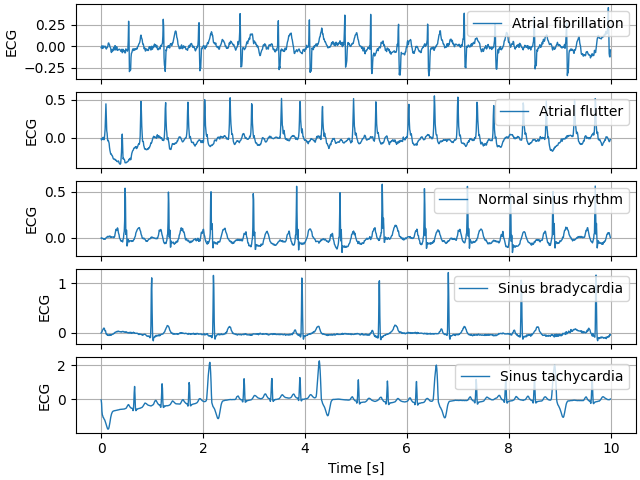

In [3]:
def plot_ecg_examples(signals, rhythms, fs):
    time = np.arange(signals.shape[-1]) / fs
    labels = np.unique(rhythms)
    indices = [np.random.choice(np.flatnonzero(rhythms == label)) for label in labels]
    
    fig, axes = plt.subplots(len(labels), 1, sharex='all', constrained_layout=True)
    for ax, index in zip(axes.flat, indices):
        label = rhythms[index].replace('_', ' ').capitalize()
        plt.sca(ax)
        plt.plot(time, signals[index].T, linewidth=1, label=label)
        plt.grid()
        plt.ylabel('ECG')
        plt.legend(loc='upper right')
    plt.xlabel('Time [s]')
    

plot_ecg_examples(signals, rhythms, fs)

**Question 1**

Visually, what are the differences between the different rhythms?

**Answer**

*Atrial fibrillation*, as it has been shown many times in the other lab sessions, shows a lot of irregularities in its PR-intervals and a shift of R and S points : instead of being respectively around 0.5 and -0.1, their values are around 0.25 and -0.25. There is also an increase in heartbeat frequency.

The *atrial flutter* signal shows a huge increase in heartbeat frequency (much bigger than the one in atrial fibrillation, nearly twice the one of the normal signal).


*Sinus bradycardia* is the opposite and shows a decrease in frequency. There is also an increase in amplitude of the R-peaks.


*Sinus tachycardia* has a signal frequency slightly lower than the *atrial flutter* one, with one every four PQRST complexes showing really extreme behaviours (extreme amplitudes of R and S points).


Then, we split that data into subsets for training, validation, and testing stratified by rhythms.

In [4]:
def split_data(rhythms):
    n = rhythms.size
    splitter = sklearn.model_selection.StratifiedKFold(n_splits=5)
    indices = list(map(operator.itemgetter(1), splitter.split(np.zeros((n, 1)), rhythms)))
    i_train = np.hstack(indices[:-2])
    i_val = indices[-2]
    i_test = indices[-1]
    
    assert np.intersect1d(i_train, i_val).size == 0
    assert np.intersect1d(i_train, i_test).size == 0
    assert np.intersect1d(i_val, i_test).size == 0
    assert np.all(np.sort(np.hstack((i_train, i_val, i_test))) == np.arange(n))
    
    return i_train, i_val, i_test


i_train, i_val, i_test = split_data(rhythms)


def build_summary(rhythms, indices):
    labels = np.unique(rhythms)
    data = []
    for subset, i in indices:
        y = rhythms[i]
        data.append({'subset': subset, 'total_count': y.size})
        for label in labels:
            data[-1][f'{label}_count'] = np.sum(y == label)
    return pd.DataFrame(data)


IPython.display.display(build_summary(rhythms, (('train', i_train), ('val', i_val), ('test', i_test))))

,subset,total_count,atrial_fibrillation_count,atrial_flutter_count,normal_sinus_rhythm_count,sinus_bradycardia_count,sinus_tachycardia_count
0,train,4500,900,900,900,900,900
1,val,1500,300,300,300,300,300
2,test,1500,300,300,300,300,300


The final preprocessing steps are to scale the ECG signals so that they have approximiately unit variance and to encode the rhythm labels with one-hot encoding.

In [5]:
def compute_scaling(signals):
    sigma = np.std(signals)
    return 1.0 / sigma


alpha = compute_scaling(signals[i_train])
signals *= alpha


def encode_rhythms(rhythms):
    categories = [np.unique(rhythms)]
    encoder = sklearn.preprocessing.OneHotEncoder(categories=categories, sparse_output=False)
    return encoder.fit_transform(rhythms[:, None])


encoded_rhythms = encode_rhythms(rhythms)


def print_encoded_rhythms(rhythms, encoded_rhythms, n=10):
    df = pd.DataFrame(encoded_rhythms, columns=np.unique(rhythms))
    df.insert(0, 'rhythm', rhythms)
    IPython.display.display(df.head(n))
    
    
print_encoded_rhythms(rhythms, encoded_rhythms)

,rhythm,atrial_fibrillation,atrial_flutter,normal_sinus_rhythm,sinus_bradycardia,sinus_tachycardia
0,atrial_fibrillation,1.0,0.0,0.0,0.0,0.0
1,sinus_bradycardia,0.0,0.0,0.0,1.0,0.0
2,sinus_bradycardia,0.0,0.0,0.0,1.0,0.0
3,atrial_flutter,0.0,1.0,0.0,0.0,0.0
4,sinus_bradycardia,0.0,0.0,0.0,1.0,0.0
5,atrial_fibrillation,1.0,0.0,0.0,0.0,0.0
6,normal_sinus_rhythm,0.0,0.0,1.0,0.0,0.0
7,sinus_bradycardia,0.0,0.0,0.0,1.0,0.0
8,sinus_bradycardia,0.0,0.0,0.0,1.0,0.0
9,sinus_bradycardia,0.0,0.0,0.0,1.0,0.0


We define a class and few utility functions for training and evaluating models.

In [6]:
class Classifier(pl.LightningModule):
    
    def __init__(self, model, learning_rate=0.001):
        super().__init__()
        self.save_hyperparameters(ignore=['model'])
        self.model = model
        self.learning_rate = learning_rate
        self.example_input_array = torch.zeros((1,) + self.model.input_shape)
        
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)
    
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        return self._run_step(batch, 'train')
    
    def validation_step(self, batch, batch_idx):
        self._run_step(batch, 'val')
        
    def test_step(self, batch, batch_idx):
        self._run_step(batch, 'test')
        
    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        x, y = batch
        return self.model(x)
    
    def _run_step(self, batch, subset):
        x, y = batch
        logits = self.model(x)
        loss = torch.nn.functional.cross_entropy(logits, y)
        acc = (torch.argmax(y, 1) == torch.argmax(logits, 1)).float().mean()
        self.log_dict({
            f'{subset}_loss': loss,
            f'{subset}_acc': acc,
        }, on_step=False, on_epoch=True, prog_bar=True)
        return loss
    
    
def build_loader(*tensors, batch_size=100, shuffle=False, n_workers=0):
    dataset = torch.utils.data.TensorDataset(*map(torch.Tensor, tensors))
    return torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=n_workers,
    )


def train_model(name, model, x, y, i_train, i_val, learning_rate=0.001, batch_size=100, n_epochs=10):
    train_loader = build_loader(x[i_train], y[i_train], batch_size=batch_size, shuffle=True)
    val_loader = build_loader(x[i_val], y[i_val], batch_size=batch_size)
    classifier = Classifier(model, learning_rate)
    print(pl.utilities.model_summary.ModelSummary(classifier, max_depth=-1))
    
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        trainer = pl.Trainer(
            default_root_dir=LOG_DIRECTORY,
            logger=pl.loggers.TensorBoardLogger(LOG_DIRECTORY, name),
            enable_model_summary=False,
            max_epochs=n_epochs,
        )
        trainer.fit(classifier, train_loader, val_loader)
        
    return classifier


def evaluate_model(model, x, y, i_train, i_val, i_test, batch_size=100):
    loader = build_loader(x, y, batch_size=batch_size)
    
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        trainer = pl.Trainer(
            default_root_dir=LOG_DIRECTORY,
            logger=False,
            enable_progress_bar=False,
            enable_model_summary=False,
        )
        z = trainer.predict(model, loader)
    z = np.vstack([u.numpy() for u in z])
    
    references = np.argmax(y, axis=1)
    predictions = np.argmax(z, axis=1)
    matrices = {}
    for subset, indices in (('train', i_train), ('val', i_val), ('test', i_test)):
        matrices[subset] = sklearn.metrics.confusion_matrix(
            references[indices], 
            predictions[indices],
        )
        
    return matrices

We start TensorBoard to visualize performance metrics during training.

If you prefer to view TensorBoard in a separate window, you can open http://localhost:6006/ in your web browser.

In [7]:
%reload_ext tensorboard
%tensorboard --logdir ../logs/ecg_rhythm_classification --port 6006

We define a convolutional neural network.

In [8]:
class CnnModel(torch.nn.Module):
    
    def __init__(self, input_shape, output_shape, kernel_size=5):
        super().__init__()
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.layers = torch.nn.Sequential(
            torch.nn.Conv1d(self.input_shape[0], 8, kernel_size, padding='same'),
            torch.nn.BatchNorm1d(8),
            torch.nn.ReLU(),
            torch.nn.MaxPool1d(2),
            
            torch.nn.Conv1d(8, 16, kernel_size, padding='same'),
            torch.nn.BatchNorm1d(16),
            torch.nn.ReLU(),
            torch.nn.MaxPool1d(2),
            
            torch.nn.Conv1d(16, 32, kernel_size, padding='same'),
            torch.nn.BatchNorm1d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool1d(2),
            
            torch.nn.Conv1d(32, 64, kernel_size, padding='same'),
            torch.nn.BatchNorm1d(64),
            torch.nn.ReLU(),
            torch.nn.AdaptiveAvgPool1d(1),
            
            torch.nn.Flatten(),
            torch.nn.Linear(64, self.output_shape[0]),
        )
        
    def forward(self, x):
        return self.layers(x)

Then, we train and evaluate this model.

In [9]:
input_shape = signals.shape[1:]
output_shape = encoded_rhythms.shape[1:]
n_epochs = 50
batch_size = 100

cnn = train_model(
    name='cnn',
    model=CnnModel(input_shape, output_shape),
    x=signals,
    y=encoded_rhythms,
    i_train=i_train,
    i_val=i_val,
    learning_rate=0.0001,
    batch_size=batch_size,
    n_epochs=n_epochs,
)

cnn_matrices = evaluate_model(
    model=cnn,
    x=signals,
    y=encoded_rhythms,
    i_train=i_train,
    i_val=i_val,
    i_test=i_test,
    batch_size=batch_size,
)

   | Name            | Type              | Params | Mode  | In sizes     | Out sizes   
---------------------------------------------------------------------------------------------
0  | model           | CnnModel          | 14.2 K | train | [1, 1, 1280] | [1, 5]      
1  | model.layers    | Sequential        | 14.2 K | train | [1, 1, 1280] | [1, 5]      
2  | model.layers.0  | Conv1d            | 48     | train | [1, 1, 1280] | [1, 8, 1280]
3  | model.layers.1  | BatchNorm1d       | 16     | train | [1, 8, 1280] | [1, 8, 1280]
4  | model.layers.2  | ReLU              | 0      | train | [1, 8, 1280] | [1, 8, 1280]
5  | model.layers.3  | MaxPool1d         | 0      | train | [1, 8, 1280] | [1, 8, 640] 
6  | model.layers.4  | Conv1d            | 656    | train | [1, 8, 640]  | [1, 16, 640]
7  | model.layers.5  | BatchNorm1d       | 32     | train | [1, 16, 640] | [1, 16, 640]
8  | model.layers.6  | ReLU              | 0      | train | [1, 16, 640] | [1, 16, 640]
9  | model.layers.7  | Max

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

After the evaluation is finished, we can plot the confusion matrices for the training, validatoin, and test sets.

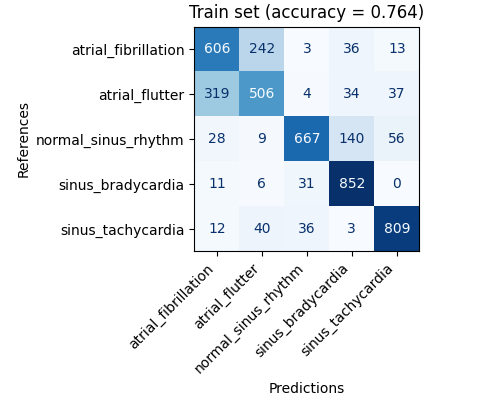

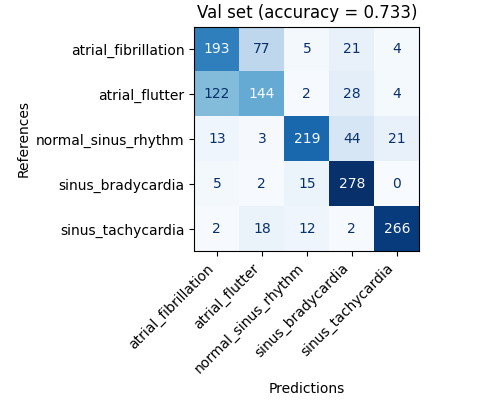

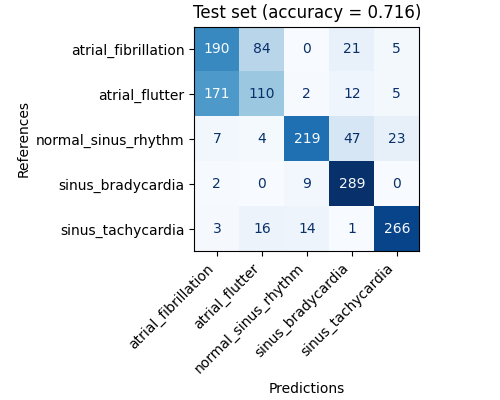

In [10]:
def plot_confusion_matrix(c, labels=None, title=None):
    c = np.asarray(c)

    fig = plt.figure(figsize=(5, 4), constrained_layout=True)
    image = plt.imshow(c, cmap='Blues', interpolation='nearest')

    threshold = (c.min() + c.max()) / 2
    for i, j in itertools.product(range(c.shape[0]), repeat=2):
        if c[i, j] < threshold:
            color = image.cmap(image.cmap.N)
        else:
            color = image.cmap(0)
        text = format(c[i, j], '.2g')
        if c.dtype.kind != 'f':
            integer_text = format(c[i, j], 'd')
            if len(integer_text) < len(text):
                text = integer_text
        plt.text(j, i, text, color=color, ha='center', va='center')

    if labels is not None:
        plt.xticks(np.arange(c.shape[-1]), labels, rotation=45, ha='right')
        plt.yticks(np.arange(c.shape[-1]), labels)
    plt.xlabel('Predictions')
    plt.ylabel('References')
    if title is not None:
        plt.title(title)



def plot_confusion_matrices(matrices, labels):
    for subset in ('train', 'val', 'test'):
        c = matrices[subset]
        accuracy = np.trace(c) / c.sum()
        title = f'{subset.capitalize()} set (accuracy = {accuracy:.3f})'
        plot_confusion_matrix(c, labels=labels, title=title)
        
        
plot_confusion_matrices(cnn_matrices, np.unique(rhythms))

**Question 2**

Comment the metrics shown in TensorBoard and the confusion matrices. Does the model overfit? Are there some rhythms that are difficult to classify?

**Answer**
The model does not overfit (0.71 for test set against 0.76 for validation). Furthermore, by inspecting the confusion matrices, we can observe that there is a cluster with atrial fibrillation and atrial flutter. In fact, these two rhythms are difficult to classify and are often confused with one another in the model.

**Question 3**

Define two custom models to classify cardiac rhythms from ECG signals.

You can directly define the layers of the custom models in the following classes.

In [ ]:
class CustomModel1(torch.nn.Module):
    
    def __init__(self, input_shape, output_shape):
        super().__init__()
        self.input_shape = input_shape
        self.output_shape = output_shape
        
        kernel_size = 5
        # Implement you own model here.
        # define two twins CNNs
        self.cnn1 = torch.nn.Sequential(
            torch.nn.Conv1d(self.input_shape[0], 8, kernel_size, padding='same'),
            torch.nn.BatchNorm1d(8),
            torch.nn.ReLU(),
            torch.nn.MaxPool1d(2),
            
            torch.nn.Conv1d(8, 16, kernel_size, padding='same'),
            torch.nn.BatchNorm1d(16),
            torch.nn.ReLU(),
            torch.nn.MaxPool1d(2),
            
            torch.nn.Conv1d(16, 32, kernel_size, padding='same'),
            torch.nn.BatchNorm1d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool1d(2),
            
            torch.nn.Conv1d(32, 64, kernel_size, padding='same'),
            torch.nn.BatchNorm1d(64),
            torch.nn.ReLU(),
            torch.nn.AdaptiveAvgPool1d(1),
        )
        self.cnn2 = torch.nn.Sequential(
            torch.nn.Conv1d(self.input_shape[0], 8, kernel_size, padding='same'),
            torch.nn.BatchNorm1d(8),
            torch.nn.ReLU(),
            torch.nn.MaxPool1d(2),
            
            torch.nn.Conv1d(8, 16, kernel_size, padding='same'),
            torch.nn.BatchNorm1d(16),
            torch.nn.ReLU(),
            torch.nn.MaxPool1d(2),
            
            torch.nn.Conv1d(16, 32, kernel_size, padding='same'),
            torch.nn.BatchNorm1d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool1d(2),
            
            torch.nn.Conv1d(32, 64, kernel_size, padding='same'),
            torch.nn.BatchNorm1d(64),
            torch.nn.ReLU(),
            torch.nn.AdaptiveAvgPool1d(1),
        )

        self.classif = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(2*64, self.output_shape[0]),
        )
        
    def forward(self, x):
        tmp = torch.concat([self.cnn1(x), self.cnn2(x)], dim=1)
        return self.classif(tmp)

    
class CustomModel2(torch.nn.Module):
    
    def __init__(self, input_shape, output_shape):
        super().__init__()
        self.input_shape = input_shape
        self.output_shape = output_shape
        
        # Implement you own model here.
        kernel_size = 3
        self.layers = torch.nn.Sequential(
            torch.nn.Conv1d(self.input_shape[0], 8, kernel_size, padding='same'),
            torch.nn.BatchNorm1d(8),
            torch.nn.ReLU(),
            torch.nn.MaxPool1d(2),
            
            torch.nn.Conv1d(8, 16, kernel_size, padding='same'),
            torch.nn.BatchNorm1d(16),
            torch.nn.ReLU(),
            torch.nn.MaxPool1d(2),
            
            torch.nn.Conv1d(16, 32, kernel_size, padding='same'),
            torch.nn.BatchNorm1d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool1d(2),
            
            torch.nn.Conv1d(32, 64, kernel_size, padding='same'),
            torch.nn.BatchNorm1d(64),
            torch.nn.ReLU(),
            torch.nn.AdaptiveAvgPool1d(1),

            torch.nn.Conv1d(64, 32, kernel_size, padding='same'),
            torch.nn.BatchNorm1d(32),
            torch.nn.ReLU(),
            torch.nn.AdaptiveAvgPool1d(1),

            torch.nn.Conv1d(32, 16, kernel_size, padding='same'),
            torch.nn.BatchNorm1d(16),
            torch.nn.ReLU(),
            torch.nn.AdaptiveAvgPool1d(1),
            
            torch.nn.Flatten(),
            torch.nn.Linear(16, self.output_shape[0]),
        )
        
    def forward(self, x):
        return self.layers(x)

You can train and evaluate the first custom model.

   | Name            | Type              | Params | Mode  | In sizes     | Out sizes   
---------------------------------------------------------------------------------------------
0  | model           | CustomModel1      | 28.3 K | train | [1, 1, 1280] | [1, 5]      
1  | model.cnn1      | Sequential        | 13.8 K | train | [1, 1, 1280] | [1, 64, 1]  
2  | model.cnn1.0    | Conv1d            | 48     | train | [1, 1, 1280] | [1, 8, 1280]
3  | model.cnn1.1    | BatchNorm1d       | 16     | train | [1, 8, 1280] | [1, 8, 1280]
4  | model.cnn1.2    | ReLU              | 0      | train | [1, 8, 1280] | [1, 8, 1280]
5  | model.cnn1.3    | MaxPool1d         | 0      | train | [1, 8, 1280] | [1, 8, 640] 
6  | model.cnn1.4    | Conv1d            | 656    | train | [1, 8, 640]  | [1, 16, 640]
7  | model.cnn1.5    | BatchNorm1d       | 32     | train | [1, 16, 640] | [1, 16, 640]
8  | model.cnn1.6    | ReLU              | 0      | train | [1, 16, 640] | [1, 16, 640]
9  | model.cnn1.7    | Max

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

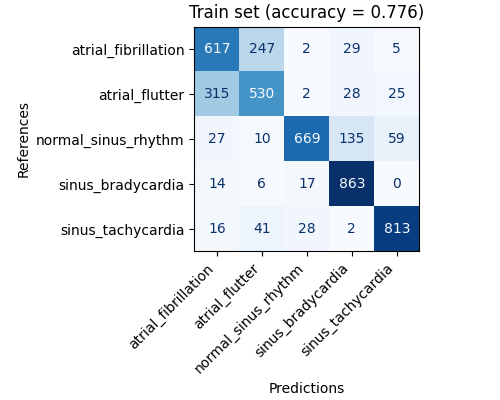

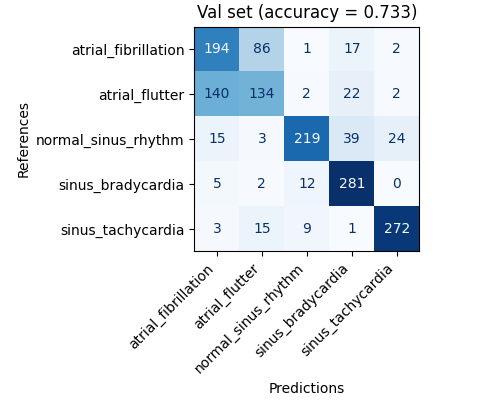

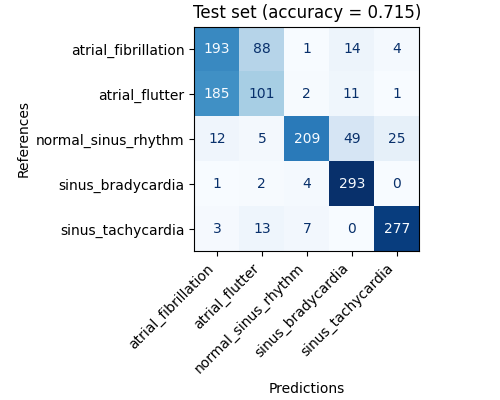

In [15]:
custom1 = train_model(
    name='custom1',
    model=CustomModel1(input_shape, output_shape),
    x=signals,
    y=encoded_rhythms,
    i_train=i_train,
    i_val=i_val,
    learning_rate=0.0001,
    batch_size=batch_size,
    n_epochs=n_epochs,
)

custom1_matrices = evaluate_model(
    model=custom1,
    x=signals,
    y=encoded_rhythms,
    i_train=i_train,
    i_val=i_val,
    i_test=i_test,
    batch_size=batch_size,
)

plot_confusion_matrices(custom1_matrices, np.unique(rhythms))

And then the second custom model.

   | Name            | Type              | Params | Mode  | In sizes     | Out sizes   
---------------------------------------------------------------------------------------------
0  | model           | CustomModel2      | 16.4 K | train | [1, 1, 1280] | [1, 5]      
1  | model.layers    | Sequential        | 16.4 K | train | [1, 1, 1280] | [1, 5]      
2  | model.layers.0  | Conv1d            | 32     | train | [1, 1, 1280] | [1, 8, 1280]
3  | model.layers.1  | BatchNorm1d       | 16     | train | [1, 8, 1280] | [1, 8, 1280]
4  | model.layers.2  | ReLU              | 0      | train | [1, 8, 1280] | [1, 8, 1280]
5  | model.layers.3  | MaxPool1d         | 0      | train | [1, 8, 1280] | [1, 8, 640] 
6  | model.layers.4  | Conv1d            | 400    | train | [1, 8, 640]  | [1, 16, 640]
7  | model.layers.5  | BatchNorm1d       | 32     | train | [1, 16, 640] | [1, 16, 640]
8  | model.layers.6  | ReLU              | 0      | train | [1, 16, 640] | [1, 16, 640]
9  | model.layers.7  | Max

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

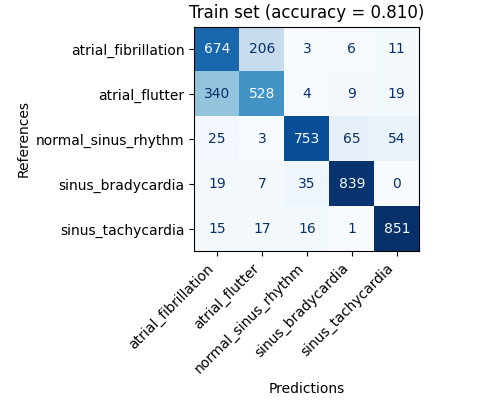

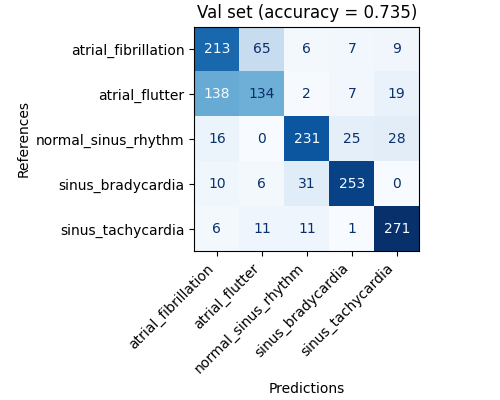

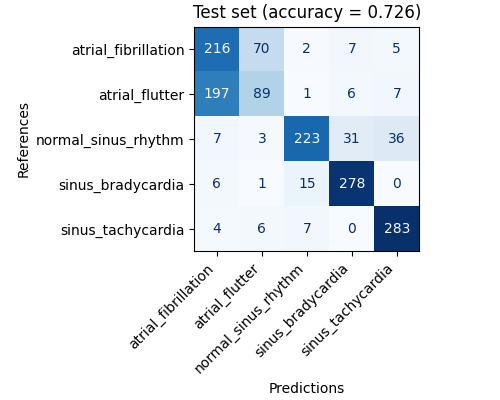

In [16]:
custom2 = train_model(
    name='custom2',
    model=CustomModel2(input_shape, output_shape),
    x=signals,
    y=encoded_rhythms,
    i_train=i_train,
    i_val=i_val,
    learning_rate=0.0001,
    batch_size=batch_size,
    n_epochs=n_epochs,
)

custom2_matrices = evaluate_model(
    model=custom2,
    x=signals,
    y=encoded_rhythms,
    i_train=i_train,
    i_val=i_val,
    i_test=i_test,
    batch_size=batch_size,
)

plot_confusion_matrices(custom2_matrices, np.unique(rhythms))

**Question 4**

How do the two custom models perform? Do they overfit? Do they outpeform the first model?

**Answer**
Both of our custom models slightly outperform the first model in terms of accuracy, but seem to struggle with `atrial_flutter` and `atrial_fibrillation` signals just like the proposed model.